# Approach 2: Generating Novel Music With Deep Convolutional Generative Adversarial   Network (DCGAN)

## Generating Muisc From Drum Beats Music File.

1. This method corresponds to Approach 2 in our paper for generating sound from DCGAN.
2. The Music file used for this approach is drum beat music data file (drum2.wav). The main reason for using drum beats is because drums produce lower frequency sounds than string instruments and we wanted to understand if the frequency range makes any difference in results of a DCGAN while producing sound. 
3. In this approach the drum2.wav file is spilt into 32 images where each image represents the frequencies in time corresposning to one beat. 
4. The wav file is 21 seconds long and thus has 32 beats in the 21 seconds because the ffdrum2.wav file is recorded at 92 beats per minute.

5. Following describes the process used in convering the drum2.wav file into greyscale images, training a DCGAN with the images  and recovering the sound back from the images generated by the generator. 

### (Please note: The process of training the DCGAN is done through a separate python program and not is not done in this python notebook. This notebook will expalin the steps to follow to train the DCGAN outside this python notebook). 

In [1]:
#Importing the necessary packages
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as a
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage
import pylab
import tensorflow as tf
import scipy.misc as mi
from PIL import Image 

In [4]:
# Most of the Spectrograms and Inversion are taken from: https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
# This function is used to pass the sound data through a filter to limit the low and the high frequency.
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))
    print ('X is', X)

    #ws = window_size
    #ss = window_step
    ws = window_size
    ss = int(window_step)
    a = X
    #print('window_step: ',window_step)
    #print('window_size: ',window_size)

    valid = len(a) - ws
    nw = int((valid) // ss)
    out = np.ndarray((nw,ws),dtype = a.dtype)

    #for i in xrange(nw):
    for i in range(nw):
        # "slide" the window along the samples
        start = i * ss
        #print('Start is', start)
        stop = start + ws
        #print ('stop is', stop)
        out[i] = a[start : stop]

    return out


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)
    
    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d,log = True, thresh= 5, fft_size = 512, step_size = 64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
        compute_onesided=True))
  
    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold
    
    return specgram

# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(X_s, log = True, fft_size = 512, step_size = 512/4, n_iter = 10):
    
    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t

def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1E8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=True)
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=False)
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[:len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                             set_zero_phase=False)
    return np.real(X_t)

def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    step=int(step)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype('float64')
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print("WARNING: Large step size >50\% detected! "
                      "This code works best with high overlap - try "
                      "with 75% or greater")
                offset_size = step
            offset = xcorr_offset(wave[wave_start:wave_start + offset_size],
                                  wave_est[est_start:est_start + offset_size])
        else:
            offset = 0
        
        wave = wave.astype('float64')
        wave[wave_start:wave_end] += win * wave_est[
            est_start - offset:est_end - offset]
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1E-6)
    return wave

def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype('float32'), x2[::-1].astype('float32'))
    corrs[:half] = -1E30
    corrs[-half:] = -1E30
    offset = corrs.argmax() - len(x1)
    return offset


def make_mel(spectrogram, mel_filter, shorten_factor = 1):
    mel_spec =np.transpose(mel_filter).dot(np.transpose(spectrogram))
    mel_spec = scipy.ndimage.zoom(mel_spec.astype('float32'), [1, 1./shorten_factor]).astype('float16')
    mel_spec = mel_spec[:,1:-1] # a little hacky but seemingly needed for clipping 
    return mel_spec

def mel_to_spectrogram(mel_spec, mel_inversion_filter, spec_thresh, shorten_factor):
    """
    takes in an mel spectrogram and returns a normal spectrogram for inversion 
    """
    mel_spec = (mel_spec+spec_thresh)
    uncompressed_spec = np.transpose(np.transpose(mel_spec).dot(mel_inversion_filter))
    uncompressed_spec = scipy.ndimage.zoom(uncompressed_spec.astype('float32'), [1,shorten_factor]).astype('float16')
    uncompressed_spec = uncompressed_spec -4
    return uncompressed_spec

In [5]:
### Parameters ###
fft_size = 2048 # window size for the FFT
step_size = fft_size/16 # distance to slide along the window (in time)
spec_thresh = 4 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 15000 # Hz # High cut for our butter bandpass filter

n_mel_freq_components = 64 # number of mel frequency channels
shorten_factor = 10 # how much should we compress the x-axis (time)
start_freq = 300 # Hz # What frequency to start sampling our melS from 
end_freq = 8000 # Hz # What frequency to stop sampling our melS from 
bpm=92 # beats per minute of the 

In [10]:
# Reading the Music file. Grab your wav and filter it
mywav = 'drum2beats/drum2.wav'
# Reading the data and the frequency rate.
rate, data = wavfile.read(mywav)
# Finding the number of seconds in the data file
seconds = int(data[:,1].shape[0]/rate)
print(seconds)
# calculating the number of beats 
beats=int((seconds/60) * bpm)
print('Beats:',beats)

# Passing the data through a band pass filter to filter the low cut and high cut frequencies. The lowcut frequency is 
# set at 500 Hz and the high cut is set at 15000 Hz
data = butter_bandpass_filter(data, lowcut, highcut, rate, order=1)
# Only use a short clip for our demo for 21 seconds.
if np.shape(data)[0]/float(rate) > 21:
    data = data[0:rate*21] 
print ('Length in time (s): ', np.shape(data)[0]/float(rate))
# Extracting the frequency data from the music data. This is the data we are going to save into images.
data=data[:,1]

C:\Users\Shreyas\Anaconda3\envs\tf\lib\site-packages\scipy\io\wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


21
Beats: 32
Length in time (s):  21.0


In [11]:
# Since there are 32 beats in the 21 seconds. 
#The length of the data is 44100*21 = 926100
# Thus length of each beat is 926100/32=28940.625
#Each beat needs to be converted into an image: the size of image is sqrt(28940.625)=170.119
#If we round it up to 170 then the size of data should be 170*170*32=924800
# Clipping the data to length of 924800
data=data[:924800]
# Finding the minimum and maximum of the data.
vmin=data.min() 
vmax=data.max()
#Spliting the frequency data into length of size of each beat.
samples=np.array_split(data, beats)
#Playing the entire drum beats sounds data file.
IPython.display.Audio(data=data, rate=rate)

In [9]:
# saving each beat into a greyscale image png of size 170 x 170. the image is name grey + (i).png
i=0
for x in samples:
    i=i+1
    filename='drum2beats/grey'+str(i)+'.png'
    img=mi.toimage(x.reshape(170,170), cmin=x.min(), cmax=x.max())
    img.save(filename)
    #unscaled = np.reshape(img, (1,np.product([170,170])))
    #reshaped=unscaled.reshape(28900)

print('Example Audio for first beat')
# Playing the first sample from the music
IPython.display.Audio(data=samples[0], rate=rate)

Example Audio for first beat


# Saving the Data and Training the our DCGAN with the Sound Images.

1. Once the images are saved in the 'drumbeats' folder. The images have to be convered into a Tfrecords file. To convert the images into Tfrecords we use the code present in create_tfrecords folder.

## Follow the below steps to convert the greyscale images into .tfrecords files.

1. Create a foler called 'drum2beats' in create_tfrecords folder. Inside this folder create another folder called 'drumbeats_data'.
2. Inside this folder drumbeats_data create another folder called 'drum2beats'.
3. Copy the images present in 'drum2beats' folder with have name grey%*%.png and paste it in the create_tfrecords/drum2beats/drumbeats_data/drum2beats 
4. In your python termial run the file create_tfrecord.py by typing the following command.
   ##### python create_tfrecord.py --dataset_dir=drum2beats/ --tfrecord_filename=drumbeats2
5. The above command will 4 Tfrecord files. two for training and two validation files in the folder 'create_tfrecords/drum2beats'. As the number of shards defined in the create_tfrecord.py is 2, the program creates two pairs of tfrecord files.

## Training Our DCGAN using the TfRecord files generated.

1. Copy the 4 Tfrecord files into the SoundDCGAN/Data folder.
2. Open the Train.py file and in the main function and in the following code make the s_size=10 the DCGAN(s_size=10). This will make the generator output images of size 160 x 160
3. Go to the path 'SoundDCGAN' folder and run the following command 
   ##### python train.py
4. This will start training the DCGAN on the data present in the Tfrecord files.
5. 'Logdir' folder inside the 'SoundDCGAN' folder will store the generator and the discriminator checkpoints after every 500 iterations. If the model has already been trained then the model will be restored from the previous check points and continue training from that point.
6. The images generated by the generator are stored in the 'SoundDCGAN/Images' folder. The images are saved in this for every 100 iterations of the training.
7. Copy these images and save them in the 'drumbeats' folder from where the following code is used to convert the image into back into sound.



 

## Recovering Sound Back From the Generator's Generated Images

1. On Training the Images are Saved in the 'SoundDCGAN/Images' folder. Copy the images from this folder and paste them inside the 'drumbeats' folder. It is from the drumbeats folder we will recover sound back from the images generated by the DCGAN's generator.

In [12]:
# Reading the image to convert back into sound.
strImg1='06100'
img1 = Image.open('drum2beats/' + strImg1 + '.png').convert('L')
#img1 = Image.open('drum2beats/06100.png').convert('L')
# Reading the image data. Since the size of the DCGAN was given as 10 the DCGAN peoduced images of size 160 x160
unscaled1 = np.reshape(img1, (1,np.product([160,160])))
# reshaping into one dimention.
reshaped1=unscaled1.reshape(25600)

# Converting the frequencies into spectrogram.
wav_spectrogram1 = pretty_spectrogram(reshaped1.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)
print('Sound recovered from GAN.')
#Playing the sound recovered from the image.
IPython.display.Audio(data=reshaped1, rate=rate)

X is [-28.17773438  -0.17773438 -53.17773438 ...,   0.           0.           0.        ]
Sound recovered from GAN.


In [13]:
scipy.io.wavfile.write('drum2beats/recovered_Sound_From_'+strImg1+'_img.wav', 44100, reshaped1)

In [14]:
# Reading another image to convert back into sound. 
strImg2='06200'
img2 = Image.open('drum2beats/' + strImg2 + '.png').convert('L')
#img2 = Image.open('drum2beats/06200.png').convert('L')
# Reading the image data. Since the size of the DCGAN was given as 10 the DCGAN peoduced images of size 160 x160
unscaled2 = np.reshape(img2, (1,np.product([160,160])))
# reshaping into one dimention.
reshaped2=unscaled2.reshape(25600)

# Converting the frequencies into spectrogram.
wav_spectrogram2 = pretty_spectrogram(reshaped2.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)
print('Sound recovered from GAN.')
#Playing the sound recovered from the image.
IPython.display.Audio(data=reshaped2, rate=rate)

X is [-15.3428125  25.6571875 -14.3428125 ...,   0.          0.          0.       ]
Sound recovered from GAN.


In [15]:
scipy.io.wavfile.write('drum2beats/recovered_Sound_From_'+strImg2+'_img.wav', 44100, reshaped2)

In [16]:
# Reading another image to convert back into sound. 
strImg3='06400'
img3 = Image.open('drum2beats/' + strImg3 + '.png').convert('L')
#img3 = Image.open('drum2beats/06400.png').convert('L')
# Reading the image data. Since the size of the DCGAN was given as 10 the DCGAN peoduced images of size 160 x160
unscaled3 = np.reshape(img3, (1,np.product([160,160])))
# reshaping into one dimention.
reshaped3=unscaled3.reshape(25600)

# Converting the frequencies into spectrogram.
wav_spectrogram3 = pretty_spectrogram(reshaped3.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)
print('Sound recovered from GAN.')
#Playing the sound recovered from the image.
IPython.display.Audio(data=reshaped3, rate=rate)

X is [ 10.29546875  60.29546875   3.29546875 ...,   0.           0.           0.        ]
Sound recovered from GAN.


In [17]:
scipy.io.wavfile.write('drum2beats/recovered_Sound_From_'+strImg3+'_img.wav', 44100, reshaped3)

In [19]:
# Reading another image to convert back into sound. 
strImg4='07500'
img4 = Image.open('drum2beats/' + strImg4 + '.png').convert('L')
#img4 = Image.open('drum2beats/06500.png').convert('L')
# Reading the image data. Since the size of the DCGAN was given as 10 the DCGAN peoduced images of size 160 x160
unscaled4 = np.reshape(img4, (1,np.product([160,160])))
# reshaping into one dimention.
reshaped4=unscaled4.reshape(25600)

# Converting the frequencies into spectrogram.
wav_spectrogram4 = pretty_spectrogram(reshaped4.astype('float64'), fft_size = fft_size, 
                                   step_size = step_size, log = True, thresh = spec_thresh)
print('Sound recovered from GAN.')
#Playing the sound recovered from the image.
IPython.display.Audio(data=reshaped4, rate=rate)

X is [ 8.04476562  6.04476562  1.04476562 ...,  0.          0.          0.        ]
Sound recovered from GAN.


In [20]:
# Saving Sound generated from image for image strImg1
scipy.io.wavfile.write('drum2beats/recovered_Sound_From_'+strImg4+'_img.wav', 44100, reshaped4)

## Combining Sound from All 4 images

In [21]:
app=np.concatenate((reshaped1,reshaped2))
app=np.concatenate((app,reshaped3))
app=np.concatenate((app,reshaped4))
print('Generated Audio Combined')
# Playing the sounds from all 4 images.
IPython.display.Audio(data=app, rate=rate)

Generated Audio Combined


In [22]:
scipy.io.wavfile.write('drum2beats/recovered_Sound_combined_img.wav', 44100, app)

 
## Another Way of Recovering the sound from image.
1. Another way of recovering sound from the image is to to convert image into spectrogram which has frequencies on the y axis and time on x axis. Since the image data represents frequencies we convert the data from the image into a spectrogram and the recover the sound from the spectrogram. This is just another way of recovering sound to see if there is any improvment in reducing noise from the recovered sound

fig is Figure(72x72)
ax is Axes(0.125,0.125;0.775x0.755)


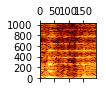

In [23]:
# Plotting the spectrogram from image 1
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(1,1))
print('fig is', fig)
print('ax is', ax)
cax = ax.matshow(np.transpose(wav_spectrogram1), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
# Saving the spectrogram
fig.savefig('drum2beats/spec1.png') # Use fig. here

fig is Figure(72x72)
ax is Axes(0.125,0.125;0.775x0.755)


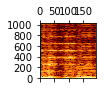

In [24]:
# Plotting the spectrogram from image 2
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(1,1))
print('fig is', fig)
print('ax is', ax)
cax = ax.matshow(np.transpose(wav_spectrogram2), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
# Saving the spectrogram
fig.savefig('drum2beats/spec2.png') # Use fig. here

fig is Figure(72x72)
ax is Axes(0.125,0.125;0.775x0.755)


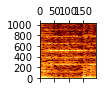

In [25]:
# Plotting the spectrogram from image 3
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(1,1))
print('fig is', fig)
print('ax is', ax)
cax = ax.matshow(np.transpose(wav_spectrogram3), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
# Saving the spectrogram
fig.savefig('drum2beats/spec3.png') # Use fig. here

fig is Figure(72x72)
ax is Axes(0.125,0.125;0.775x0.755)


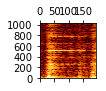

In [26]:
# Plotting the spectrogram from image 4
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(1,1))
print('fig is', fig)
print('ax is', ax)
cax = ax.matshow(np.transpose(wav_spectrogram4), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
# Saving the spectrogram
fig.savefig('drum2beats/spec4.png') # Use fig. here

In [27]:
# Recovering the audio from the spectrogram generated from image 1.
recovered_audio_orig1 = invert_pretty_spectrogram(wav_spectrogram1, fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)

print('Audio generated spectrogram of image 1 generated by GAN')
IPython.display.Audio(data=recovered_audio_orig1, rate=rate) # play the audio

X is [ 0.00020933  0.00019747  0.0002264  ...,  0.          0.          0.        ]
X is [ 0.0006591   0.00057981  0.00081061 ...,  0.          0.          0.        ]
X is [ 0.00029675  0.00024756  0.00015584 ...,  0.          0.          0.        ]
X is [ 0.00057255  0.00058357  0.00118548 ...,  0.          0.          0.        ]
X is [ -1.56470710e-04   2.31994141e-05  -5.25928778e-05 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ 0.00062608  0.00051073  0.00060191 ...,  0.          0.          0.        ]
X is [-0.0004141  -0.00025868 -0.00043215 ...,  0.          0.          0.        ]
X is [  5.21818661e-05   2.20704994e-04   2.00743231e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ 0.00027779  0.00025117  0.00019714 ...,  0.          0.          0.        ]
X is [  7.73774513e-05   9.19568821e-05   1.63848439e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
Audio generated spectrogram of image 1 generated by GAN


In [28]:
# Recovering the audio from the spectrogram generated from image 2
recovered_audio_orig2 = invert_pretty_spectrogram(wav_spectrogram2, fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)

print('Audio generated spectrogram of image 2 generated by GAN')
IPython.display.Audio(data=recovered_audio_orig2, rate=rate) # play the audio

X is [ 0.00016986  0.00014615  0.00012094 ...,  0.          0.          0.        ]
X is [  5.27803633e-05   1.17158479e-04   1.82262253e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [-0.00065082 -0.00071191 -0.00057594 ...,  0.          0.          0.        ]
X is [ 0.00060911  0.00055673  0.00069148 ...,  0.          0.          0.        ]
X is [-0.00057627 -0.00042037 -0.0003274  ...,  0.          0.          0.        ]
X is [ 0.00026576  0.00023728  0.00029004 ...,  0.          0.          0.        ]
X is [-0.00014391 -0.00014324 -0.00025016 ...,  0.          0.          0.        ]
X is [ -4.51473185e-05   3.72186394e-05   1.10682470e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ -1.31919907e-04  -6.55535169e-05  -1.37111433e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ 0.00052258  0.00056259  0.00050271 ...,  0.          0.          0.        ]
Audio generated spectrogram of image 2 generated by GAN


In [29]:
# Recovering the audio from the spectrogram generated from image 3
recovered_audio_orig3 = invert_pretty_spectrogram(wav_spectrogram3, fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)

print('Audio generated spectrogram of image 3 generated by GAN')
IPython.display.Audio(data=recovered_audio_orig3, rate=rate) # play the audio

X is [ 0.0001661   0.00023035  0.00024186 ...,  0.          0.          0.        ]
X is [ 0.00099062  0.0010912   0.00127219 ...,  0.          0.          0.        ]
X is [ 0.0001889   0.00016101  0.00013003 ...,  0.          0.          0.        ]
X is [ 0.00109096  0.00095628  0.0009929  ...,  0.          0.          0.        ]
X is [-0.00056535 -0.00075166 -0.0005003  ...,  0.          0.          0.        ]
X is [ 0.00068372  0.00051498  0.00062715 ...,  0.          0.          0.        ]
X is [  9.09003072e-05   2.87179325e-04   2.23827711e-04 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ 0.00063322  0.0005254   0.00059099 ...,  0.          0.          0.        ]
X is [ 0.00035708  0.00031931  0.00019259 ...,  0.          0.          0.        ]
X is [ 0.00032168  0.00047263  0.00052678 ...,  0.          0.          0.        ]
Audio generated spectrogram of image 3 generated by GAN


In [30]:
# Recovering the audio from the spectrogram generated from image 4
recovered_audio_orig4 = invert_pretty_spectrogram(wav_spectrogram4, fft_size = fft_size,
                                            step_size = step_size, log = True, n_iter = 10)

print('Audio generated spectrogram of image 4 generated by GAN')
IPython.display.Audio(data=recovered_audio_orig4, rate=rate) # play the audio

X is [ -2.41417866e-05  -2.03899358e-05  -5.48713978e-06 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ -6.55383706e-05  -6.41930207e-05  -9.62501821e-05 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ -2.41081870e-05  -1.48413228e-05  -3.19539173e-05 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [  6.92395441e-05   9.24490449e-05   2.94051815e-05 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ -4.90626123e-05  -3.11970288e-05  -4.12805033e-06 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [  3.73238712e-05   2.20770840e-05   3.76948256e-05 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [ -5.19874113e-05  -1.02165404e-04  -5.40815666e-05 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [  4.90165438e-06   4.94783441e-05   2.61207777e-05 ...,   0.00000000e+00
   0.00000000e+00   0.00000000e+00]
X is [-0.00017451 -0.00010974 -0.00012504 ...,  0.          0.          0.      